In [ ]:
import pandas as pd
file_path = 'train.csv'
data = pd.read_csv(file_path)


column_names = data.columns.tolist()
print(column_names)

['MONTH', 'TOWN', 'FLAT_TYPE', 'BLOCK', 'STREET', 'FLOOR_RANGE', 'FLOOR_AREA_SQM', 'FLAT_MODEL', 'ECO_CATEGORY', 'LEASE_COMMENCE_DATA', 'RESALE_PRICE']


### 1. Temporal Features

In [2]:
import pandas as pd
import numpy as np


CSV_PATH = 'train.csv'
df = pd.read_csv(CSV_PATH)


df["_MONTH_DT"] = pd.to_datetime(df["MONTH"], format="%Y-%m", errors="coerce")


if df["_MONTH_DT"].isna().any():
    failed = df.loc[df["_MONTH_DT"].isna(), "MONTH"].head(5).tolist()



df["TX_YEAR"] = df["_MONTH_DT"].dt.year

df["TX_YEAR"] = df["TX_YEAR"].astype(int)


df["TX_YEAR_STD"] = (df["TX_YEAR"] - df["TX_YEAR"].mean()) / df["TX_YEAR"].std()

print(df[["MONTH", "TX_YEAR", "TX_YEAR_STD"]].head())

     MONTH  TX_YEAR  TX_YEAR_STD
0  2025-06     2025     1.625115
1  2020-01     2020    -0.425203
2  2025-06     2025     1.625115
3  2022-10     2022     0.394924
4  2024-02     2024     1.215051


In [3]:
# ===== 3) T2: Transaction_Month_Sin/Cos=====
tx_month = df["_MONTH_DT"].dt.month
df["TX_MONTH_SIN"] = np.sin(2 * np.pi * tx_month / 12.0)
df["TX_MONTH_COS"] = np.cos(2 * np.pi * tx_month / 12.0)

In [4]:
# ===== 5) T4: Building_Age=====

df["BUILDING_AGE_RAW"] = df["TX_YEAR"] - df["LEASE_COMMENCE_DATA"]
df["BUILDING_AGE"] = df["BUILDING_AGE_RAW"].clip(lower=0)

k = 0.05


df["BUILDING_AGE_DECAY"] = np.exp(-k * df["BUILDING_AGE"])


print(df[["BUILDING_AGE", "BUILDING_AGE_DECAY"]].head(10))

   BUILDING_AGE  BUILDING_AGE_DECAY
0             7            0.704688
1            17            0.427415
2            52            0.074274
3            35            0.173774
4            36            0.165299
5            15            0.472367
6            40            0.135335
7            22            0.332871
8             4            0.818731
9            32            0.201897


In [5]:
# ===== 6) T5: Lease_Remaining_Years=====
df["LEASE_REMAINING_YEARS"] = (99 - df["BUILDING_AGE"]).clip(lower=0, upper=99)
df["LEASE_RATIO"] = df["LEASE_REMAINING_YEARS"] / 99.0
df["LEASE_RATIO_LOG"] = np.log1p(df["LEASE_REMAINING_YEARS"]) / np.log1p(99)
df["LEASE_RATIO_SQRT"] = np.sqrt(df["LEASE_REMAINING_YEARS"] / 99.0)

In [6]:
# ===== 7) T6: Rolling_Price_Growth_Rate=====


df_train = pd.read_csv("train.csv")
df_train["_MONTH_DT"] = pd.to_datetime(df["MONTH"], format="%Y-%m", errors="coerce")

df_train["_MONTH_DT"] = pd.to_datetime(df_train["_MONTH_DT"])

town_month = (
    df_train.assign(_YM=df["_MONTH_DT"].dt.to_period("M"))
      .groupby(["TOWN", "_YM"], as_index=False)["RESALE_PRICE"].mean()
      .rename(columns={"RESALE_PRICE": "MEAN_PRICE_TOWN_YM"})
      .sort_values(["TOWN", "_YM"])
)


town_month["ROLL_MEAN_3M"] = (
    town_month
    .groupby("TOWN", group_keys=False)["MEAN_PRICE_TOWN_YM"]
    .apply(lambda s: s.rolling(window=3, min_periods=3).mean())
)


town_month["ROLL_MEAN_3M_LAG3"] = (
    town_month
    .groupby("TOWN", group_keys=False)["ROLL_MEAN_3M"]
    .shift(3)
)
town_month["ROLL_GROWTH_3M"] = (
    (town_month["ROLL_MEAN_3M"] - town_month["ROLL_MEAN_3M_LAG3"])
    / town_month["ROLL_MEAN_3M_LAG3"]
)

df["_YM"] = df["_MONTH_DT"].dt.to_period("M")
df = df.merge(
    town_month[["TOWN", "_YM", "ROLL_GROWTH_3M"]],
    on=["TOWN", "_YM"],
    how="left"
)
df["ROLLING_PRICE_GROWTH_3M_TOWN"] = df["ROLL_GROWTH_3M"]

In [7]:
# ===== 8) T7: Time_Since_Last_Transaction=====

month_index = df["_MONTH_DT"].dt.year * 12 + df["_MONTH_DT"].dt.month
df["MONTH_INDEX"] = month_index

df = df.sort_values(["BLOCK", "_MONTH_DT"])
df["MONTHS_SINCE_LAST_TX_BLOCK"] = (
    df.groupby("BLOCK", group_keys=False)["MONTH_INDEX"].diff()
)

df = df.sort_index()

In [8]:
# ===== 9) Clean the middle column =====
# drop_cols = ["_MONTH_DT", "_QTR", "QTR_MEAN_PRICE", "_YM",
#              "BUILDING_AGE_RAW", "ROLL_MEAN_3M", "ROLL_MEAN_3M_LAG3",
#              "ROLL_GROWTH_3M", "MONTH_INDEX"]
drop_cols = ["_MONTH_DT", "_QTR", "QTR_MEAN_PRICE", "_YM",
             "BUILDING_AGE_RAW", "ROLL_MEAN_3M", "ROLL_MEAN_3M_LAG3",
             "ROLL_GROWTH_3M", "MONTH_INDEX"]
df.drop(columns=[c for c in drop_cols if c in df.columns], inplace=True)


print("\n[INFO] new：",
      ["TX_YEAR","TX_MONTH_SIN","TX_MONTH_COS","QUARTER_INDEX",
       "BUILDING_AGE","LEASE_REMAINING_YEARS",
       "ROLLING_PRICE_GROWTH_3M_TOWN","MONTHS_SINCE_LAST_TX_BLOCK"]
)

print(df[[
"MONTH","TOWN","BLOCK",
"TX_YEAR","TX_MONTH_SIN","TX_MONTH_COS",
"BUILDING_AGE","LEASE_REMAINING_YEARS",
"ROLLING_PRICE_GROWTH_3M_TOWN","MONTHS_SINCE_LAST_TX_BLOCK"
]].head(10))


[INFO] 新增列： ['TX_YEAR', 'TX_MONTH_SIN', 'TX_MONTH_COS', 'QUARTER_INDEX', 'BUILDING_AGE', 'LEASE_REMAINING_YEARS', 'ROLLING_PRICE_GROWTH_3M_TOWN', 'MONTHS_SINCE_LAST_TX_BLOCK']
     MONTH           TOWN BLOCK  TX_YEAR  TX_MONTH_SIN  TX_MONTH_COS  \
0  2025-06      sembawang  115D     2025  1.224647e-16     -1.000000   
1  2020-01    bukit merah  118A     2020  5.000000e-01      0.866025   
2  2025-06         bishan    22     2025  1.224647e-16     -1.000000   
3  2022-10        hougang   635     2022 -8.660254e-01      0.500000   
4  2024-02  bukit panjang   275     2024  8.660254e-01      0.500000   
5  2018-01        punggol  104A     2018  5.000000e-01      0.866025   
6  2025-06    jurong west   430     2025  1.224647e-16     -1.000000   
7  2020-07    jurong west   267     2020 -5.000000e-01     -0.866025   
8  2022-10      woodlands  785B     2022 -8.660254e-01      0.500000   
9  2017-02         yishun   261     2017  8.660254e-01      0.500000   

   BUILDING_AGE  LEASE_REMAINI

In [9]:
df.to_csv("train.csv", index=False)

### 2. Economic Environment Features

In [1]:
import pandas as pd


df = pd.read_csv("train.csv")
df['date_column'] = pd.to_datetime(df['MONTH'])

min_date = df['date_column'].min()
max_date = df['date_column'].max()

print(f"min：{min_date}")
print(f"max：{max_date}")

最小日期：2017-01-01 00:00:00
最大日期：2025-07-01 00:00:00


In [2]:
print(df.columns)

Index(['ID', 'MONTH', 'TOWN', 'FLAT_TYPE', 'BLOCK', 'STREET', 'FLOOR_RANGE',
       'FLOOR_AREA_SQM', 'FLAT_MODEL', 'LEASE_COMMENCE_DATA', 'PRICE_PER_SQM',
       'FLOOR_AVG', 'FLAT_TYPE_ENCODED', 'AVG_STREET_PPS', 'SPECIAL_MODEL',
       'RESALE_PRICE', 'TX_YEAR', 'TX_YEAR_STD', 'TX_MONTH_SIN',
       'TX_MONTH_COS', 'QUARTER_INDEX', 'BUILDING_AGE', 'BUILDING_AGE_DECAY',
       'LEASE_REMAINING_YEARS', 'LEASE_RATIO', 'LEASE_RATIO_LOG',
       'LEASE_RATIO_SQRT', 'ROLLING_PRICE_GROWTH_3M_TOWN',
       'MONTHS_SINCE_LAST_TX_BLOCK', 'date_column'],
      dtype='object')


### E1 E2

In [1]:
import pandas as pd


main = pd.read_csv("train.csv")
aux = pd.read_csv("au-data/COE.csv")


main['month'] = pd.to_datetime(main['MONTH'], format='%Y-%m')
aux['month'] = pd.to_datetime(aux['month'], errors='coerce')




cols_to_merge = ['month', 'coe_avg_premium', 'coe_change_rate']
aux_monthly = aux[cols_to_merge]
merged = pd.merge(main, aux_monthly, on='month', how='left')


merged.to_csv("train.csv", index=False)


### E3

In [2]:
import pandas as pd

main = pd.read_csv("train.csv")
aux = pd.read_csv("au-data/STI.csv")


main['month'] = pd.to_datetime(main['MONTH'], format='%Y-%m')
aux['month'] = pd.to_datetime(aux['month'], errors='coerce')


cols_to_merge = ['month', 'STI_Close_Mean', 'STI_Close_Last']
aux_monthly = aux[cols_to_merge]
merged = pd.merge(main, aux_monthly, on='month', how='left')


merged.to_csv("train.csv", index=False)

### E4

In [3]:
import pandas as pd

main = pd.read_csv("train.csv")
aux = pd.read_csv("au-data/CPI.csv")


main['month'] = pd.to_datetime(main['MONTH'], format='%Y-%m')
aux['month'] = pd.to_datetime(aux['month'], errors='coerce')


cols_to_merge = ['month', 'CPI_VALUE', 'CPI_GROWTH_RATE']
aux_monthly = aux[cols_to_merge]
merged = pd.merge(main, aux_monthly, on='month', how='left')


merged.to_csv("train.csv", index=False)

### E5

In [4]:
import pandas as pd

main = pd.read_csv("train.csv")
aux = pd.read_csv("au-data/SORA.csv")


main['month'] = pd.to_datetime(main['MONTH'], format='%Y-%m')
aux['month'] = pd.to_datetime(aux['month'], errors='coerce')


cols_to_merge = ['month', 'sora_3m_mean']
aux_monthly = aux[cols_to_merge]
merged = pd.merge(main, aux_monthly, on='month', how='left')


merged.to_csv("train.csv", index=False)

### E6

In [5]:
import pandas as pd

main = pd.read_csv("train.csv")
aux = pd.read_csv("au-data/GDP.csv")


main['month'] = pd.to_datetime(main['MONTH'], format='%Y-%m')
aux['month'] = pd.to_datetime(aux['month'], errors='coerce')


cols_to_merge = ['month', 'GDP_Growth_Rate']
aux_monthly = aux[cols_to_merge]
merged = pd.merge(main, aux_monthly, on='month', how='left')


merged.to_csv("train.csv", index=False)

In [7]:
import pandas as pd
import numpy as np

df = pd.read_csv("train.csv")

print(df.columns)

df.drop(columns=["month"], inplace=True)

print(df.columns)

df.to_csv("train.csv", index=False)

Index(['ID', 'MONTH', 'TOWN', 'FLAT_TYPE', 'BLOCK', 'STREET', 'FLOOR_RANGE',
       'FLOOR_AREA_SQM', 'FLAT_MODEL', 'LEASE_COMMENCE_DATA', 'FLOOR_AVG',
       'FLAT_TYPE_ENCODED', 'AVG_STREET_PPS', 'SPECIAL_MODEL', 'TX_YEAR',
       'TX_YEAR_STD', 'TX_MONTH_SIN', 'TX_MONTH_COS', 'BUILDING_AGE',
       'BUILDING_AGE_DECAY', 'LEASE_REMAINING_YEARS', 'LEASE_RATIO',
       'LEASE_RATIO_LOG', 'LEASE_RATIO_SQRT', 'ROLLING_PRICE_GROWTH_3M_TOWN',
       'MONTHS_SINCE_LAST_TX_BLOCK', 'month', 'coe_avg_premium',
       'coe_change_rate', 'STI_Close_Mean', 'STI_Close_Last', 'CPI_VALUE',
       'CPI_GROWTH_RATE', 'sora_3m_mean', 'GDP_Growth_Rate'],
      dtype='object')
Index(['ID', 'MONTH', 'TOWN', 'FLAT_TYPE', 'BLOCK', 'STREET', 'FLOOR_RANGE',
       'FLOOR_AREA_SQM', 'FLAT_MODEL', 'LEASE_COMMENCE_DATA', 'FLOOR_AVG',
       'FLAT_TYPE_ENCODED', 'AVG_STREET_PPS', 'SPECIAL_MODEL', 'TX_YEAR',
       'TX_YEAR_STD', 'TX_MONTH_SIN', 'TX_MONTH_COS', 'BUILDING_AGE',
       'BUILDING_AGE_DECAY', 'LEASE_R

Done. Saved: fig_temporal_vs_price.png, fig_economic_vs_price.png


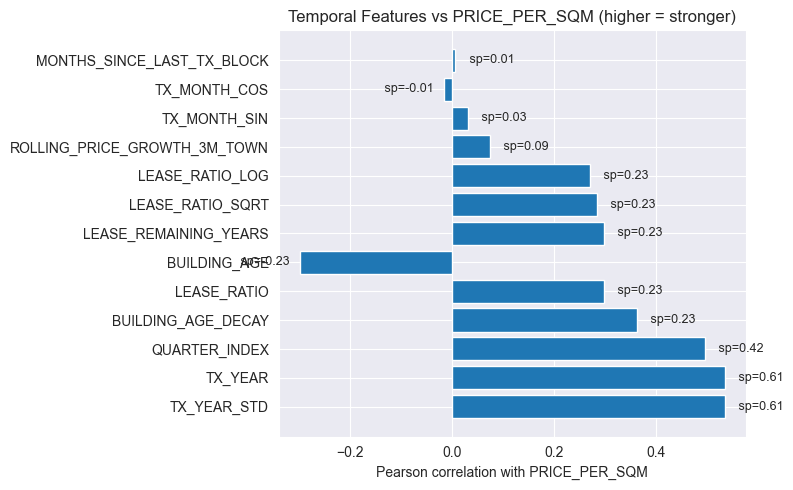

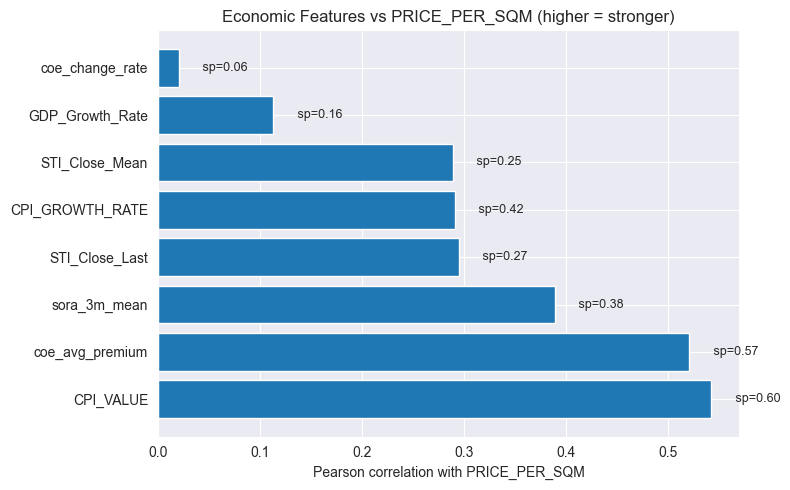

In [1]:
# ==== Config ====
csv_path = "train.csv"


temporal_features_all = [
    'TX_YEAR', 'TX_YEAR_STD', 'TX_MONTH_SIN','TX_MONTH_COS',
    'BUILDING_AGE', 'BUILDING_AGE_DECAY', 'LEASE_REMAINING_YEARS',
    'LEASE_RATIO', 'LEASE_RATIO_LOG', 'LEASE_RATIO_SQRT',
    'ROLLING_PRICE_GROWTH_3M_TOWN', 'MONTHS_SINCE_LAST_TX_BLOCK'
]
economic_features_all = [
    'coe_avg_premium', 'coe_change_rate', 'STI_Close_Mean', 'STI_Close_Last',
    'CPI_VALUE', 'CPI_GROWTH_RATE', 'sora_3m_mean', 'GDP_Growth_Rate'
]

# ==== Code ====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


df = pd.read_csv(csv_path)

target_col = 'PRICE_PER_SQM'
assert target_col in df.columns, f"目标列 {target_col} 不在CSV中"


temporal_features = [c for c in temporal_features_all if c in df.columns]
economic_features = [c for c in economic_features_all if c in df.columns]


def _clean_numeric(s: pd.Series):
    s = pd.to_numeric(s, errors='coerce')
    return s


def compute_correlations(df, features, target):
    rows = []
    y = _clean_numeric(df[target])
    for f in features:
        x = _clean_numeric(df[f])
        ok = x.notna() & y.notna()
        if ok.sum() < 3:
            continue
        pearson = np.corrcoef(x[ok], y[ok])[0,1]
        spearman = x[ok].rank().corr(y[ok].rank())
        rows.append((f, pearson, spearman))
    corr_df = pd.DataFrame(rows, columns=['feature','pearson','spearman'])

    corr_df['abs_pearson'] = corr_df['pearson'].abs()
    corr_df = corr_df.sort_values('abs_pearson', ascending=False)
    return corr_df[['feature','pearson','spearman']]


corr_temporal = compute_correlations(df, temporal_features, target_col)
corr_economic = compute_correlations(df, economic_features, target_col)


plt.figure(figsize=(8, 5))
features = corr_temporal['feature'].tolist()
vals = corr_temporal['pearson'].values

y_pos = np.arange(len(features))
plt.barh(y_pos, vals)
plt.yticks(y_pos, features)
plt.xlabel('Pearson correlation with PRICE_PER_SQM')
plt.title('Temporal Features vs PRICE_PER_SQM (higher = stronger)')


spearman_vals = corr_temporal['spearman'].values
for i, (v, sp) in enumerate(zip(vals, spearman_vals)):
    txt = f" sp={sp:.2f}"

    x_text = v + (0.02 if v >= 0 else -0.02)
    ha = 'left' if v >= 0 else 'right'
    plt.text(x_text, i, txt, va='center', ha=ha, fontsize=9)

plt.tight_layout()
plt.savefig('fig_temporal_vs_price.png', dpi=300)

plt.figure(figsize=(8, 5))
features = corr_economic['feature'].tolist()
vals = corr_economic['pearson'].values

y_pos = np.arange(len(features))
plt.barh(y_pos, vals)
plt.yticks(y_pos, features)
plt.xlabel('Pearson correlation with PRICE_PER_SQM')
plt.title('Economic Features vs PRICE_PER_SQM (higher = stronger)')


spearman_vals = corr_economic['spearman'].values
for i, (v, sp) in enumerate(zip(vals, spearman_vals)):
    txt = f" sp={sp:.2f}"
    x_text = v + (0.02 if v >= 0 else -0.02)
    ha = 'left' if v >= 0 else 'right'
    plt.text(x_text, i, txt, va='center', ha=ha, fontsize=9)

plt.tight_layout()
plt.savefig('fig_economic_vs_price.png', dpi=300)


print("Done. Saved: fig_temporal_vs_price.png, fig_economic_vs_price.png")
